Using device: cuda
Epoch 1/100 | Loss: 1.0108 | Val Acc: 48.89%
保存最佳模型！
Epoch 2/100 | Loss: 0.9170 | Val Acc: 60.55%
保存最佳模型！
Epoch 3/100 | Loss: 0.8586 | Val Acc: 57.88%
Epoch 4/100 | Loss: 0.8126 | Val Acc: 59.13%
Epoch 5/100 | Loss: 0.7837 | Val Acc: 62.15%
保存最佳模型！
Epoch 6/100 | Loss: 0.7588 | Val Acc: 54.50%
Epoch 7/100 | Loss: 0.7495 | Val Acc: 66.79%
保存最佳模型！
Epoch 8/100 | Loss: 0.7239 | Val Acc: 57.88%
Epoch 9/100 | Loss: 0.7270 | Val Acc: 67.23%
保存最佳模型！
Epoch 10/100 | Loss: 0.7163 | Val Acc: 64.74%
Epoch 11/100 | Loss: 0.7058 | Val Acc: 65.72%
Epoch 12/100 | Loss: 0.6967 | Val Acc: 68.48%
保存最佳模型！
Epoch 13/100 | Loss: 0.6692 | Val Acc: 67.32%
Epoch 14/100 | Loss: 0.6769 | Val Acc: 68.92%
保存最佳模型！
Epoch 15/100 | Loss: 0.6586 | Val Acc: 65.54%
Epoch 16/100 | Loss: 0.6486 | Val Acc: 70.53%
保存最佳模型！
Epoch 17/100 | Loss: 0.6477 | Val Acc: 69.55%
Epoch 18/100 | Loss: 0.6201 | Val Acc: 66.87%
Epoch 19/100 | Loss: 0.6311 | Val Acc: 70.53%
Epoch 20/100 | Loss: 0.6225 | Val Acc: 66.70%
Epoch 

C:\Users\enine\AppData\Local\Temp\ipykernel_47504\4206017604.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_loc

Test Accuracy: 85.32%
混淆矩阵：
[[370  51  10]
 [ 44 271  38]
 [  2  20 318]]


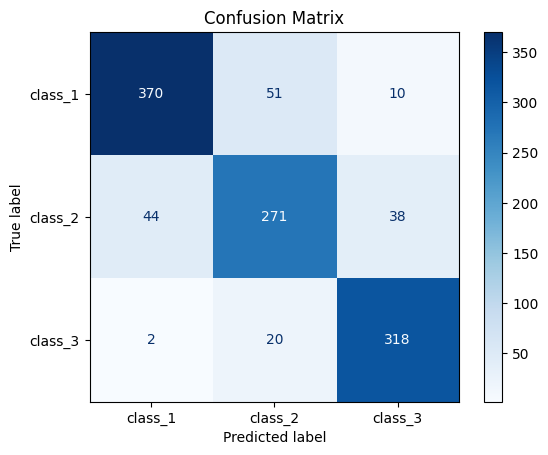

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 自定义数据集类
class EnhancedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                images.append((img_path, self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# CBAM模块定义
class ChannelAttention(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.se = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_result = self.maxpool(x)
        avg_result = self.avgpool(x)
        max_out = self.se(max_result)
        avg_out = self.se(avg_result)
        output = self.sigmoid(max_out + avg_out)
        return output

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_result, _ = torch.max(x, dim=1, keepdim=True)
        avg_result = torch.mean(x, dim=1, keepdim=True)
        result = torch.cat([max_result, avg_result], 1)
        output = self.conv(result)
        output = self.sigmoid(output)
        return output

class CBAMBlock(nn.Module):
    def __init__(self, channel=512, reduction=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channel=channel, reduction=reduction)
        self.sa = SpatialAttention(kernel_size=kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

# 带CBAM的分类模型
class CBAMClassifier(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super().__init__()
        
        # 基础卷积模块
        self.base = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            CBAMBlock(channel=64, reduction=16),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            CBAMBlock(channel=128, reduction=16),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.base(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# 训练配置
def train_model():
    # 检查GPU是否可用
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 数据预处理
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 增大
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.GaussianBlur(5),
        transforms.RandomHorizontalFlip(),
    ])

    # 加载数据集
    dataset = EnhancedDataset(
        root_dir=r"L:\常惠林\萎凋\自然萎凋\分类",
        transform=transform
    )
    
    # 按6:2:2划分训练集、验证集和测试集
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # 初始化模型并移动到GPU
    model = CBAMClassifier(num_classes=len(dataset.classes)).to(device)

    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

    # 训练循环
    best_acc = 0.0
    for epoch in range(100):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 数据移动到GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 验证阶段
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # 数据移动到GPU
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/100 | Loss: {running_loss/len(train_loader):.4f} | Val Acc: {val_acc:.2f}%")

        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("保存最佳模型！")

    # 测试阶段
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 数据移动到GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_acc:.2f}%")

    # 计算混淆矩阵并显示
    cm = confusion_matrix(all_labels, all_preds)
    print("混淆矩阵：")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

if __name__ == "__main__":
    train_model()


Using device: cuda
Epoch 1/100 | Train Loss: 1.0179 | Train Acc: 0.4803 | Val Loss: 0.9328 | Val Acc: 0.5343
保存最佳模型！
Epoch 2/100 | Train Loss: 0.9050 | Train Acc: 0.5470 | Val Loss: 0.8209 | Val Acc: 0.6287
保存最佳模型！
Epoch 3/100 | Train Loss: 0.8317 | Train Acc: 0.6031 | Val Loss: 0.8820 | Val Acc: 0.5610
Epoch 4/100 | Train Loss: 0.7896 | Train Acc: 0.6215 | Val Loss: 0.7750 | Val Acc: 0.6260
Epoch 5/100 | Train Loss: 0.7655 | Train Acc: 0.6405 | Val Loss: 0.7244 | Val Acc: 0.6776
保存最佳模型！
Epoch 6/100 | Train Loss: 0.7558 | Train Acc: 0.6509 | Val Loss: 0.7251 | Val Acc: 0.6625
Epoch 7/100 | Train Loss: 0.7417 | Train Acc: 0.6489 | Val Loss: 0.7499 | Val Acc: 0.6474
Epoch 8/100 | Train Loss: 0.7243 | Train Acc: 0.6690 | Val Loss: 0.6913 | Val Acc: 0.6955
保存最佳模型！
Epoch 9/100 | Train Loss: 0.7151 | Train Acc: 0.6756 | Val Loss: 0.6871 | Val Acc: 0.6874
Epoch 10/100 | Train Loss: 0.6932 | Train Acc: 0.6818 | Val Loss: 0.6751 | Val Acc: 0.7115
保存最佳模型！
Epoch 11/100 | Train Loss: 0.6897 | Trai

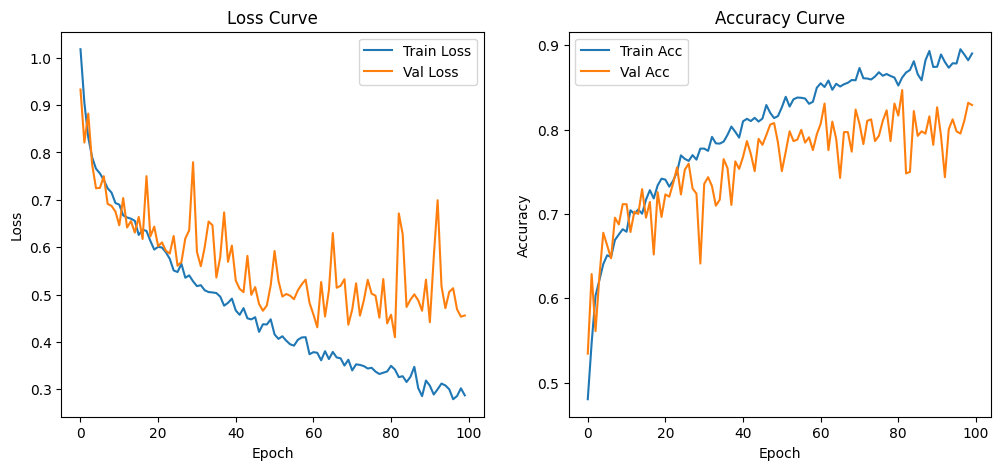

C:\Users\enine\AppData\Local\Temp\ipykernel_31336\137770427.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_loca

Test Accuracy: 82.03%
混淆矩阵：
[[356  58   6]
 [ 32 236  63]
 [  7  36 330]]


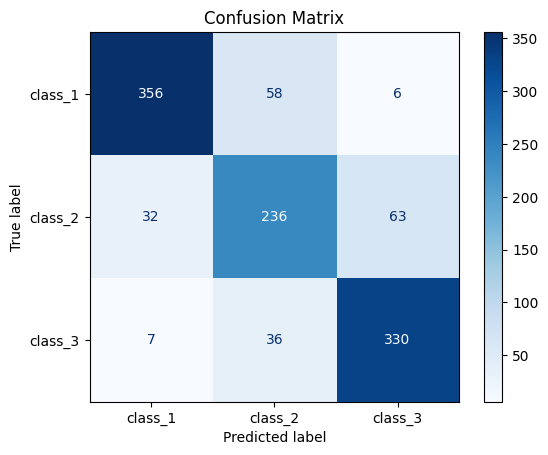

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 自定义数据集类
class EnhancedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                images.append((img_path, self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# CBAM模块定义
class ChannelAttention(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.se = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_result = self.maxpool(x)
        avg_result = self.avgpool(x)
        max_out = self.se(max_result)
        avg_out = self.se(avg_result)
        output = self.sigmoid(max_out + avg_out)
        return output

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_result, _ = torch.max(x, dim=1, keepdim=True)
        avg_result = torch.mean(x, dim=1, keepdim=True)
        result = torch.cat([max_result, avg_result], 1)
        output = self.conv(result)
        output = self.sigmoid(output)
        return output

class CBAMBlock(nn.Module):
    def __init__(self, channel=512, reduction=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channel=channel, reduction=reduction)
        self.sa = SpatialAttention(kernel_size=kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

# 带CBAM的分类模型
class CBAMClassifier(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super().__init__()
        
        # 基础卷积模块
        self.base = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            CBAMBlock(channel=64, reduction=16),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            CBAMBlock(channel=128, reduction=16),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.base(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# 训练配置
def train_model():
    # 检查GPU是否可用
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 数据预处理
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 增大
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.GaussianBlur(5),
        transforms.RandomHorizontalFlip(),
    ])

    # 加载数据集
    dataset = EnhancedDataset(
        root_dir=r"L:\常惠林\萎凋\自然萎凋\分类",
        transform=transform
    )
    
    # 按6:2:2划分训练集、验证集和测试集
    total_size = len(dataset)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # 创建数据加载器（设置 batch_size 为 64）
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # 初始化模型并移动到GPU
    model = CBAMClassifier(num_classes=len(dataset.classes)).to(device)

    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

    # 用于记录训练和验证过程的指标
    num_epochs = 100
    best_acc = 0.0
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total_train += labels.size(0)
        epoch_loss = running_loss / total_train
        epoch_acc = running_correct / total_train
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # 验证阶段
        model.eval()
        val_running_loss = 0.0
        val_running_correct = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_correct += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_loss = val_running_loss / total_val
        val_acc = val_running_correct / total_val
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/100 | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("保存最佳模型！")

    # 绘制训练/验证曲线
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.show()

    # 测试阶段
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_acc:.2f}%")

    # 计算混淆矩阵并显示
    cm = confusion_matrix(all_labels, all_preds)
    print("混淆矩阵：")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

if __name__ == "__main__":
    train_model()
